In [1]:
from sklearn.experimental import enable_iterative_imputer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay, make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
df_model = pd.read_excel("E Commerce Dataset.xlsx", sheet_name = 'E Comm')
df_model.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
df_model.drop('CustomerID', axis = 1, inplace = True)

In [5]:
listItem = []

for col in df_model.columns:
    listItem.append([col, df_model[col].dtype, df_model[col].nunique(), df_model[col].unique()])

df_desc = pd.DataFrame(columns = ['Feature', 'Data Type', 'Number of Unique', 'Unique'], data = listItem)
df_desc

,Feature,Data Type,Number of Unique,Unique
0,Churn,int64,2,"[1, 0]"
1,Tenure,float64,36,"[4.0, nan, 0.0, 13.0, 11.0, 9.0, 19.0, 20.0, 1..."
2,PreferredLoginDevice,object,3,"[Mobile Phone, Phone, Computer]"
3,CityTier,int64,3,"[3, 1, 2]"
4,WarehouseToHome,float64,34,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, ..."
5,PreferredPaymentMode,object,7,"[Debit Card, UPI, CC, Cash on Delivery, E wall..."
6,Gender,object,2,"[Female, Male]"
7,HourSpendOnApp,float64,6,"[3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]"
8,NumberOfDeviceRegistered,int64,6,"[3, 4, 5, 2, 1, 6]"
9,PreferedOrderCat,object,6,"[Laptop & Accessory, Mobile, Mobile Phone, Oth..."


In [6]:
numerical_var = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_var = ['PreferredLoginDevice', 'CityTier', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain']

In [7]:
df_model['PreferedOrderCat'].replace({'Mobile' : 'Mobile Phone'}, inplace = True)
df_model['PreferredPaymentMode'].replace({'CC' : 'Credit Card', 'COD' : 'Cash on Delivery'}, inplace = True)
df_model['PreferredLoginDevice'].replace({'Phone' : 'Mobile Phone'}, inplace = True)

# Feature Engineering

## Data Encoding

For the encoding, we will use the following for each of the categorical features:
1. Preferred Login Device will be encoded using the one-hot encoding since it has a few amount of unique values and there is no order to the data.
2. Preferred Payment Mode will be encoded using binary encoding, since it had quite large amount of unique values, and also no order to the data.
3. Gender will be encoded using the one-hot encoding since it has only 2 unique values and no order to the data.
4. Preferred Order Category will be encoded using binary encoding since it has quite large amount of unique values and no order to the data.
5. Marital Status will be encoded using the one-hot encoding since it has few unique values and no order to the data.

For imputing the missing values we will try using 3 imputers, the simple imputer with the median strategy since all of the column that will be imputed are numerical values that is not normally distributed. The KNN Imputer, and the Iterative Imputer with the initial strategy of Median for the same reason that we use the median strategy for the simple imputer

In [8]:
imputer_var = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
one_hot_var = ['PreferredLoginDevice', 'Gender', 'MaritalStatus']
binary_var = ['PreferredPaymentMode', 'PreferedOrderCat']
cat_var = ['PreferredLoginDevice', 'Gender', 'MaritalStatus', 'PreferredPaymentMode', 'PreferedOrderCat']

In [9]:
remainder = ['CityTier', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain']

In [10]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

In [11]:
numeric_transformer_knn = Pipeline(steps = [
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

In [12]:
numeric_transformer_iter = Pipeline(steps = [
    ('imputer', IterativeImputer(initial_strategy = 'median', random_state = 2021)),
    ('scaler', StandardScaler())
])

In [13]:
cat_transfomer1 = ColumnTransformer([
    ('onehot', OneHotEncoder(), cat_var)
], remainder='drop')

In [14]:
transformer_simple2 = ColumnTransformer([
    ('numtransformer', numeric_transformer, numerical_var),
    ('onehot', OneHotEncoder(), cat_var),
], remainder='passthrough')

In [15]:
transformer_knn = ColumnTransformer([
    ('numtransformer', numeric_transformer_knn, numerical_var),
    ('onehot', OneHotEncoder(), cat_var),
], remainder='passthrough')

In [16]:
transformer_iter = ColumnTransformer([
    ('numtransformer', numeric_transformer_iter, numerical_var),
    ('onehot', OneHotEncoder(), cat_var),
], remainder='passthrough')

# Model Training

## Choosing a Model using Cross-Validation

We will first use cross-validation to select which model produces better results in the metrics, we will first check the ROC-AUC score as the scoring metric in this step.

While we are cross validate the model, we will also try some of the imputer method that sklearn provides, namely, SimpleImputer method, KNNImputer method, and the IterativeImputer method

The models that we are cross-validating are:
1. Logistic Regression: A linear model that is used for classification, the model uses a logistic function, to describe the probabilities of possible outcomes
2. KNN: A machine learning model that classifies data into target variables by calculating the nearest neighbors that is classified on each point.
3. Decision Tree: A machine learning model that predicts the target variable by learning decision that splits the data to classify the result, decision tree will keep splitting until the parameters are fulfilled, whether the tree has reached its maximum depth or the split no longer produces a good split
4. Random Forest: a machine learning model that fits multiple decision tree on various samples that is chosen randomly with the final result being a majority vote.
5. XGBoost: a machine learning model that first creates a weak learner and then update the model by increasing the weights where the data is incorrectly predicted.

In [17]:
x = df_model.drop('Churn', axis = 1)
y = df_model['Churn']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.3,
    random_state = 1,
    stratify = y
)

In [19]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)

In [20]:
models = [logreg, knn, dt, rf, xgb]
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1 score' : make_scorer(f1_score),
           'roc-auc score' : make_scorer(roc_auc_score)}
score = []
mean = []
std = []

for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
    ('preprocess',transformer_simple2),
    ('model',i)
    ])
  model_cv = cross_val_score(pipeline, x_train, y_train, cv = skfold, scoring = 'roc_auc')
  score.append(model_cv)
  mean.append(model_cv.mean())
  std.append(model_cv.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [21]:
score_array = np.array(score)
score_array = score_array.transpose()
df_cv_simple = pd.DataFrame(
    data = {'Models' : ['Logistic Regression', 'KNeighbors', 'Decision Tree', 'Random Forest', 'XGBoost'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean, 
            'ROC-AUC Score Standard Deviation' : std})
df_cv_simple.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest,0.983404,0.981292,0.981134,0.972490,0.958457,0.975355,0.009243
XGBoost,0.932870,0.929970,0.944212,0.928049,0.918866,0.930793,0.008183
KNeighbors,0.937907,0.921950,0.923486,0.923624,0.903725,0.922138,0.010879
Logistic Regression,0.886095,0.886317,0.901464,0.893049,0.885393,0.890464,0.006159
Decision Tree,0.873447,0.870288,0.868077,0.811628,0.873248,0.859338,0.023938


As can be seen above the highest mean of the ROC-AUC score produced by the model is the model using the Random Forest.

In [22]:
for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
    ('preprocess',transformer_simple2),
    ('model',i)
    ])
  pipeline.fit(x_train, y_train)
  y_pred_simple = pipeline.predict(x_test)
  print(i, '\n\nROC-AUC Score:', roc_auc_score(y_test, y_pred_simple), '\n\n', classification_report(y_test, y_pred_simple))

LogisticRegression() 

ROC-AUC Score: 0.7396233271515211 

               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1405
           1       0.77      0.51      0.61       284

    accuracy                           0.89      1689
   macro avg       0.84      0.74      0.78      1689
weighted avg       0.88      0.89      0.88      1689

KNeighborsClassifier() 

ROC-AUC Score: 0.7703210365395219 

               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1405
           1       0.85      0.56      0.68       284

    accuracy                           0.91      1689
   macro avg       0.89      0.77      0.81      1689
weighted avg       0.91      0.91      0.90      1689

DecisionTreeClassifier() 

ROC-AUC Score: 0.9220289709788984 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1405
           1       0.86      0.87      0.87       2

## KNN Imputer

Next, we will try using the KNN Imputer to fill the missing data

In [23]:
models = [logreg, knn, dt, rf, xgb]
score = []
mean = []
std = []

for i in models:
  skfold = StratifiedKFold(n_splits = 5)
  pipeline = Pipeline([
    ('preprocess',transformer_knn),
    ('model',i)
    ])
  model_cv = cross_val_score(pipeline, x_train, y_train, cv=skfold, scoring='roc_auc')
  score.append(model_cv)
  mean.append(model_cv.mean())
  std.append(model_cv.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [24]:
score_array = np.array(score)
score_array = score_array.transpose()
df_cv_knn = pd.DataFrame(
    data = {'Models' : ['Logistic Regression', 'KNeighbors', 'Decision Tree', 'Random Forest', 'XGBoost'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean, 
            'ROC-AUC Score Standard Deviation' : std})
df_cv_knn.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest,0.978830,0.983116,0.980176,0.964007,0.965643,0.974355,0.007920
XGBoost,0.932159,0.930409,0.947001,0.928680,0.921713,0.931992,0.008300
KNeighbors,0.943529,0.919230,0.916949,0.923383,0.908340,0.922286,0.011703
Logistic Regression,0.891894,0.889620,0.903759,0.892843,0.888699,0.893363,0.005409
Decision Tree,0.893717,0.864214,0.864908,0.825024,0.872542,0.864081,0.022253


In [25]:
for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
      ('preprocess',transformer_knn),
      ('model',i)
      ])
  pipeline.fit(x_train, y_train)
  y_pred_knn = pipeline.predict(x_test)
  print(i, '\nROC-AUC Score:', roc_auc_score(y_test, y_pred_knn), '\n', classification_report(y_test, y_pred_knn))

LogisticRegression() 
ROC-AUC Score: 0.7325622775800713 
               precision    recall  f1-score   support

           0       0.91      0.97      0.93      1405
           1       0.74      0.50      0.60       284

    accuracy                           0.89      1689
   macro avg       0.82      0.73      0.77      1689
weighted avg       0.88      0.89      0.88      1689

KNeighborsClassifier() 
ROC-AUC Score: 0.7745351110220039 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1405
           1       0.84      0.57      0.68       284

    accuracy                           0.91      1689
   macro avg       0.88      0.77      0.81      1689
weighted avg       0.91      0.91      0.90      1689

DecisionTreeClassifier() 
ROC-AUC Score: 0.9146308455716505 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1405
           1       0.85      0.86      0.86       284

  

## Iterative Imputer

And next, we will try using the iterative imputer

In [26]:
models = [logreg, knn, dt, rf, xgb]
score = []
mean = []
std = []

for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
    ('preprocess',transformer_iter),
    ('model',i)
    ])
  model_cv = cross_val_score(pipeline, x_train, y_train, cv=skfold, scoring='roc_auc')
  score.append(model_cv)
  mean.append(model_cv.mean())
  std.append(model_cv.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [27]:
score_array = np.array(score)
score_array = score_array.transpose()
df_cv_iter = pd.DataFrame(
    data = {'Models' : ['Logistic Regression', 'KNeighbors', 'Decision Tree', 'Random Forest', 'XGBoost'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean, 
            'ROC-AUC Score Standard Deviation' : std})
df_cv_iter.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest,0.982997,0.978046,0.980922,0.970889,0.956764,0.973924,0.009507
XGBoost,0.932675,0.933793,0.947449,0.928267,0.923331,0.933103,0.008066
KNeighbors,0.939420,0.921390,0.916484,0.922780,0.908965,0.921808,0.010046
Logistic Regression,0.889522,0.888823,0.904827,0.895977,0.890949,0.894020,0.005955
Decision Tree,0.880966,0.866523,0.852161,0.846226,0.867141,0.862604,0.012251


In [28]:
for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
      ('preprocess',transformer_iter),
      ('model',i)
      ])
  pipeline.fit(x_train, y_train)
  y_pred = pipeline.predict(x_test)
  print(i, '\nROC-AUC Score:', roc_auc_score(y_test, y_pred), '\n', classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression() 
ROC-AUC Score: 0.7346787128464739 
               precision    recall  f1-score   support

           0       0.91      0.97      0.93      1405
           1       0.75      0.50      0.60       284

    accuracy                           0.89      1689
   macro avg       0.83      0.73      0.77      1689
weighted avg       0.88      0.89      0.88      1689

KNeighborsClassifier() 
ROC-AUC Score: 0.7773632900606486 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      1405
           1       0.86      0.57      0.69       284

    accuracy                           0.91      1689
   macro avg       0.89      0.78      0.82      1689
weighted avg       0.91      0.91      0.91      1689

DecisionTreeClassifier() 
ROC-AUC Score: 0.9177961004460928 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1405
           1       0.85      0.87      0.86       284

  

Also, regarding the model selection, for all of the imputer, the model that produces the highest ROC-AUC score average for training data is the RandomForestClassifier, and for the test data prediction, the DecisionTreeClassifier does have a higher ROC-AUC Score, but, the overall classification metrics is better in the RandomForestClassifier, with the exception of the positive recall. Also since the training score of the decision tree is lower than the test score.

Thus, for this dataset, the model that will be used is the RandomForestClassifier

In [60]:
pipeline_simple = Pipeline([
    ('preprocess',transformer_simple2),
    ('model', rf)
    ])
pipeline_knn = Pipeline([
    ('preprocess',transformer_knn),
    ('model', rf)
    ])
pipeline_iter = Pipeline([
    ('preprocess',transformer_iter),
    ('model', rf)
    ])
pipeline_simple.fit(x_train, y_train)
y_pred_simple = pipeline_simple.predict(x_test)
pipeline_knn.fit(x_train, y_train)
y_pred_knn = pipeline_knn.predict(x_test)
pipeline_iter.fit(x_train, y_train)
y_pred_iter = pipeline_iter.predict(x_test)
print('Simple Imputer\nROC-AUC Score:', roc_auc_score(y_test, y_pred_simple), '\n', classification_report(y_test, y_pred_simple))
print('KNN Imputer\nROC-AUC Score:', roc_auc_score(y_test, y_pred_knn), '\n', classification_report(y_test, y_pred_knn))
print('Iterative Imputer\nROC-AUC Score:', roc_auc_score(y_test, y_pred_iter), '\n', classification_report(y_test, y_pred_iter))

Simple Imputer
ROC-AUC Score: 0.8908074783218886 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.79      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.89      0.92      1689
weighted avg       0.96      0.96      0.96      1689

KNN Imputer
ROC-AUC Score: 0.8834281489649641 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1405
           1       0.97      0.77      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.88      0.92      1689
weighted avg       0.96      0.96      0.96      1689

Iterative Imputer
ROC-AUC Score: 0.8767417673299585 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1405
           1       0.98      0.76      0.85       284

    accuracy                 

It seems that overall, the performance of the models are better using the simple imputer, thus, we will use the simple imputer to fill all the missing values

# Testing New Features

Next, we will try to create new features and add them to the dataframe

In [30]:
df_model_new = df_model.copy()

In [31]:
df_model_new['CashbackPerTenure'] = df_model['CashbackAmount']/df_model['Tenure']
df_model_new['OrderCoupon'] = df_model['OrderCount']/df_model['CouponUsed']

In [51]:
df_model_new.replace([np.inf, -np.inf], 0, inplace=True)

In [52]:
new_numerical_var = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'CashbackPerTenure', 'OrderCoupon']

In [53]:
transformer_simple_new = ColumnTransformer([
    ('numtransformer', numeric_transformer, new_numerical_var),
    ('onehot', OneHotEncoder(), cat_var),
], remainder='passthrough')

In [54]:
x_new = df_model_new.drop('Churn', axis = 1)
y_new = df_model_new['Churn']

In [55]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(
    x_new,
    y_new,
    test_size = 0.3,
    random_state = 1,
    stratify = y_new
)

In [56]:
models = [logreg, knn, dt, rf, xgb]
score = []
mean = []
std = []

for i in models:
  skfold = StratifiedKFold(n_splits=5)
  pipeline = Pipeline([
    ('preprocess', transformer_simple_new),
    ('model', i)
    ])
  model_cv = cross_val_score(pipeline, x_train_new, y_train_new, cv = skfold, scoring = 'roc_auc')
  score.append(model_cv)
  mean.append(model_cv.mean())
  std.append(model_cv.std())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [57]:
score_array = np.array(score)
score_array = score_array.transpose()
df_cv_new = pd.DataFrame(
    data = {'Models' : ['Logistic Regression', 'KNeighbors', 'Decision Tree', 'Random Forest', 'XGBoost'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean, 
            'ROC-AUC Score Standard Deviation' : std})
df_cv_new.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest,0.978309,0.976528,0.977541,0.958750,0.964157,0.971057,0.008045
XGBoost,0.936721,0.933423,0.945348,0.927464,0.918590,0.932309,0.008971
KNeighbors,0.902112,0.899200,0.911686,0.899638,0.869408,0.896409,0.014235
Logistic Regression,0.885900,0.888061,0.902864,0.891798,0.883682,0.890461,0.006755
Decision Tree,0.859779,0.876340,0.860500,0.797297,0.889106,0.856604,0.031586


In [62]:
skfold = StratifiedKFold(n_splits=5)
pipeline_new = Pipeline([
    ('preprocess', transformer_simple_new),
    ('model', rf)
    ])
pipeline_new.fit(x_train_new, y_train_new)
y_pred_new = pipeline_new.predict(x_test_new)
print('Without New Features\nROC-AUC Score:', roc_auc_score(y_test, y_pred_simple), '\n', classification_report(y_test, y_pred_simple))
print('With New Features\nROC-AUC Score:', roc_auc_score(y_test, y_pred_new), '\n', classification_report(y_test, y_pred_new))

Without New Features
ROC-AUC Score: 0.8908074783218886 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.79      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.89      0.92      1689
weighted avg       0.96      0.96      0.96      1689

With New Features
ROC-AUC Score: 0.8735389203548695 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1405
           1       0.94      0.76      0.84       284

    accuracy                           0.95      1689
   macro avg       0.95      0.87      0.90      1689
weighted avg       0.95      0.95      0.95      1689



It seems with the new features, the overall performance go down slightly, thus it is better to not use the new features

## Oversampling Methods

Since the Data is imbalanced, we will try to apply some oversampling method to see if there are any improvement in the model.

### Random Over Sampling

First, we will try to apply the Random Oversampling method to oversample the dataset.

In [63]:
rf = RandomForestClassifier(random_state = 42)

In [97]:
score = []
mean = []
std = []

skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
pipeline = Pipeline([
    ('preprocess', transformer_simple2),
    ('model', rf)
    ])
pipeline_ros = Pipeline([
    ('preprocess', transformer_simple2),
    ('ros', RandomOverSampler(random_state = 42)),
    ('model', rf)
    ])
model_cv_before = cross_val_score(pipeline, x_train, y_train, cv=skfold, scoring = 'roc_auc')
score.append(model_cv_before)
mean.append(model_cv_before.mean())
std.append(model_cv_before.std())
model_cv_after = cross_val_score(pipeline_ros, x_train, y_train, cv=skfold, scoring = 'roc_auc')
score.append(model_cv_after)
mean.append(model_cv_after.mean())
std.append(model_cv_after.std())

In [98]:
score_array = np.array(score)
score_array = score_array.transpose()
score_array

array([[0.97550087, 0.98210847],
       [0.97631421, 0.97906851],
       [0.96952878, 0.97439017],
       [0.98345865, 0.98129484],
       [0.97145153, 0.96935086]])

In [99]:
df_cv = pd.DataFrame(
    data = {'Models' : ['Random Forest Before Oversampling', 'Random Forest with OverSampling'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean,
            'ROC-AUC Score Standard Deviation' : std})
df_cv.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest with OverSampling,0.982108,0.979069,0.974390,0.981295,0.969351,0.977243,0.004772
Random Forest Before Oversampling,0.975501,0.976314,0.969529,0.983459,0.971452,0.975251,0.004811


In [100]:
pipeline.fit(x_train, y_train)
y_pred_before = pipeline.predict(x_test)
print('Before Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_before), '\n', classification_report(y_test, y_pred_before))
pipeline_ros.fit(x_train, y_train)
y_pred_after_ros = pipeline.predict(x_test)
print('After Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_after_ros), '\n', classification_report(y_test, y_pred_after_ros))

Before Oversampling
ROC-AUC Score: 0.8908074783218886 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.79      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.89      0.92      1689
weighted avg       0.96      0.96      0.96      1689

After Oversampling
ROC-AUC Score: 0.9319933837902862 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.95      0.87      0.91       284

    accuracy                           0.97      1689
   macro avg       0.96      0.93      0.95      1689
weighted avg       0.97      0.97      0.97      1689



It seems that, after using the random oversampling, the ROC-AUC Score of the training data mean ROC-AUC is 0.977243 with a standarad deviation of 0.004772, while, the ROC-AUC Score for the test is increased by approximately 0.02 and the overall performance such as, the negative precision, the positive recall, the positive f1-score, and accuracy is increased.

### SMOTE(Synthetic Minority Oversampling Technique)

Next, we will try to use SMOTE for the oversampling.

In [68]:
score = []
mean = []
std = []

skfold = StratifiedKFold(n_splits = 5)
pipeline = Pipeline([
    ('preprocess', transformer_simple2),
    ('model', rf)
    ])
pipeline_smote = Pipeline([
    ('preprocess', transformer_simple2),
    ('smote', SMOTE(random_state = 42)),
    ('model', rf)
])
model_cv_before = cross_val_score(pipeline, x_train, y_train, cv=skfold, scoring = 'roc_auc')
score.append(model_cv_before)
mean.append(model_cv_before.mean())
std.append(model_cv_before.std())
model_cv_after = cross_val_score(pipeline_smote, x_train, y_train, cv=skfold, scoring = 'roc_auc')
score.append(model_cv_after)
mean.append(model_cv_after.mean())
std.append(model_cv_after.std())

In [69]:
score_array = np.array(score)
score_array = score_array.transpose()
score_array
df_cv = pd.DataFrame(
    data = {'Models' : ['Random Forest Before Oversampling', 'Random Forest with OverSampling'], 
            'ROC-AUC Score 1' : score_array[0], 
            'ROC-AUC Score 2' : score_array[1], 
            'ROC-AUC Score 3' : score_array[2], 
            'ROC-AUC Score 4' : score_array[3], 
            'ROC-AUC Score 5' : score_array[4], 
            'ROC-AUC Score Mean' : mean,
            'ROC-AUC Score Standard Deviation' : std})
df_cv.set_index('Models').sort_values('ROC-AUC Score Mean', ascending = False)

,ROC-AUC Score 1,ROC-AUC Score 2,ROC-AUC Score 3,ROC-AUC Score 4,ROC-AUC Score 5,ROC-AUC Score Mean,ROC-AUC Score Standard Deviation
Models,,,,,,,
Random Forest Before Oversampling,0.983404,0.981292,0.981134,0.972490,0.958457,0.975355,0.009243
Random Forest with OverSampling,0.977249,0.973502,0.976738,0.960793,0.952293,0.968115,0.009907


In [70]:
pipeline.fit(x_train, y_train)
y_pred_before = pipeline.predict(x_test)
print('Before Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_before), '\n', classification_report(y_test, y_pred_before))
pipeline_smote.fit(x_train, y_train)
y_pred_after_smote = pipeline_smote.predict(x_test)
print('After Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_after_smote), '\n', classification_report(y_test, y_pred_after_smote))

Before Oversampling
ROC-AUC Score: 0.8908074783218886 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.79      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.89      0.92      1689
weighted avg       0.96      0.96      0.96      1689

After Oversampling
ROC-AUC Score: 0.898542679564934 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.95      0.81      0.87       284

    accuracy                           0.96      1689
   macro avg       0.95      0.90      0.92      1689
weighted avg       0.96      0.96      0.96      1689



With SMOTE, the training ROC-AUC score averages is decreased, as opposed to the random oversampler technique where it increases by a little, with SMOTE producing ROC-AUC Score with mean of 0.968089 with standard deviation of 0.007001, it actually reduced the training score by a little with the test score, it produces a ROC-AUC Score of 0.89148162, which is a little lower than the ROC-AUC score of the model without oversampling with an increase of ROC-AUC score of 0.09, with increases in negative recall, positive recall, and positive f1-score, however, the positive precision is slightly reduced.

## Oversampling Results

In [71]:
print('Before Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_before), '\n', classification_report(y_test, y_pred_before))
print('SMOTE Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_after_smote), '\n', classification_report(y_test, y_pred_after_smote))
print('Random Oversampling\nROC-AUC Score:', roc_auc_score(y_test, y_pred_after_ros), '\n', classification_report(y_test, y_pred_after_ros))

Before Oversampling
ROC-AUC Score: 0.8908074783218886 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.96      0.79      0.86       284

    accuracy                           0.96      1689
   macro avg       0.96      0.89      0.92      1689
weighted avg       0.96      0.96      0.96      1689

SMOTE Oversampling
ROC-AUC Score: 0.898542679564934 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1405
           1       0.95      0.81      0.87       284

    accuracy                           0.96      1689
   macro avg       0.95      0.90      0.92      1689
weighted avg       0.96      0.96      0.96      1689

Random Oversampling
ROC-AUC Score: 0.9319933837902862 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.95      0.87      0.91       284

    accuracy    

From the above classification report, random oversampler produces a result with increases in the classification metrics with little decreased performance in the positve precision and negative recall, however, the positive recall had an increase of 0.06 and the ROC-AUC score is increased by 0.03 and SMOTE produces a result that overall lower performance, random oversampler will be used.

## Hyperparameter Tuning

For the next step, we will try to do some hyperparameter tuning and see if we can make the model perform better.

Since the model that will be used is the Random Forest, here are the hyperparameters that will be tuned:
1. Max Depth: How long is the path between the root node and the leaf node, default is None, the higher the depth is, the trees will start to overfit, thus, it is ideal to not put a high value in the max depth.
2. min_samples_split: The minimum amount of samples required in a node to split into nodes, default is 2 
3. min_samples_leaf: The minimum amount of samples that a leaf node to have, default is 1.
4. n_estimators: How many trees that will be in the Random Forest, the performance of the model will usually increases until it stagnates at a certain amount, higher amount will use up more computational power, thus it is better to not go over the stagnation point, default is 100.
5. max_features: Maximum number of features that is considered when looking for the best split, default = 'sqrt'   

In [72]:
pipeline2 = Pipeline([
    ('preprocess', transformer_simple2),
    ('ros', RandomOverSampler(random_state = 42)),
    ('model', RandomForestClassifier(random_state = 42))
    ])

In [101]:
hyperparam = [{
    'model__max_depth' : [10, 20, 30],
    'model__min_samples_split' : [2, 3, 4],
    'model__min_samples_leaf' : [1, 2, 3],
    'model__n_estimators' : [100, 150, 200],
    'model__max_features' : ['sqrt', 'log2', None]
}]

In [102]:
grid = GridSearchCV(pipeline2, n_jobs = 4, param_grid = hyperparam, scoring = 'roc_auc', cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42))

In [103]:
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9853332843881853
{'model__max_depth': 30, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


Best Parameter:
- Max Depth: 30
- Max Features: sqrt(the Square Root of total amount of features)
- Min Samples Leaf: 1
- Min Sample Split: 2
- n_estimators: 200

In [104]:
tuned_model = grid.best_estimator_
tuned_model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numtransformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'NumberOfAddress',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed', 'OrderCount',
                                     

In [77]:
pipeline2.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numtransformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Tenure', 'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'NumberOfAddress',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed', 'OrderCount',
                                     

In [78]:
y_pred_default = pipeline2.predict(x_test)
y_pred_proba_default = pipeline2.predict_proba(x_test)
y_pred_tuned = tuned_model.predict(x_test)
y_pred_proba_tuned = tuned_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_default)
roc_auc_tuned = roc_auc_score(y_test, y_pred_tuned)

print('Before Tuning\n\nROC-AUC Score: ', roc_auc_default, '\n\n', classification_report(y_test, y_pred_default))
print('After Tuning\n\nROC-AUC Score: ', roc_auc_tuned, '\n\n', classification_report(y_test, y_pred_tuned))

Before Tuning

ROC-AUC Score:  0.9319933837902862 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1405
           1       0.95      0.87      0.91       284

    accuracy                           0.97      1689
   macro avg       0.96      0.93      0.95      1689
weighted avg       0.97      0.97      0.97      1689

After Tuning

ROC-AUC Score:  0.9348027667786076 

               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1405
           1       0.94      0.88      0.91       284

    accuracy                           0.97      1689
   macro avg       0.96      0.93      0.95      1689
weighted avg       0.97      0.97      0.97      1689



From above classification reports, while there are some decreases in the positive precision, there is a slight increase in the positive recall. 

Next, we will plot the roc-auc graph and the confusion matrix

Text(0.5, 1.0, 'Default Parameter Model ROC-AUC Curve')

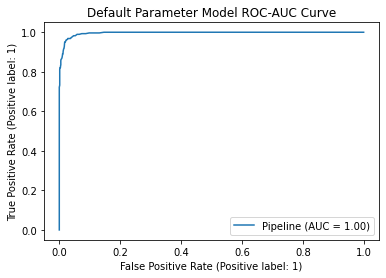

In [79]:
RocCurveDisplay.from_estimator(pipeline2, x_test, y_test)
plt.title('Default Parameter Model ROC-AUC Curve')

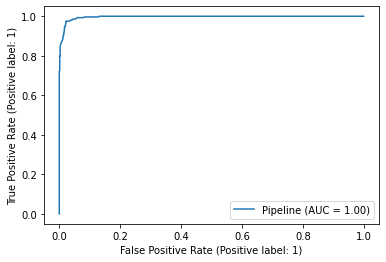

In [80]:
RocCurveDisplay.from_estimator(tuned_model, x_test, y_test)

Text(0.5, 1.0, 'Default Parameter Model Confusion Matrix')

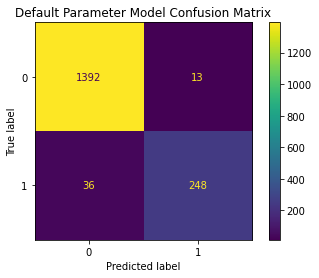

In [81]:
ConfusionMatrixDisplay.from_estimator(pipeline2, x_test, y_test)
plt.title('Default Parameter Model Confusion Matrix')

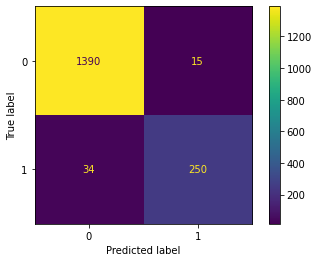

In [82]:
ConfusionMatrixDisplay.from_estimator(tuned_model, x_test, y_test)

Overall, the performance of the tuned model is slightly better, as can be seen the ROC-AUC score increases by 0.03. And from the confusion matrix, it can be seen while there is a decrease in the true negative value by 2, and an increase of false positive by 2, The true negative increases by 2 and false positive decreases by 2.

For this dataset, we are aiming to maximize the recall value therefore, from the classification report it can be seen that the tuned model produced a better positive recall value.

Thus, the tuned model will be used.

# Feature Importances

In [83]:
cat_transfomer1.fit(x_train)
feat = cat_transfomer1.get_feature_names()
feat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['onehot__x0_Computer',
 'onehot__x0_Mobile Phone',
 'onehot__x1_Female',
 'onehot__x1_Male',
 'onehot__x2_Divorced',
 'onehot__x2_Married',
 'onehot__x2_Single',
 'onehot__x3_Cash on Delivery',
 'onehot__x3_Credit Card',
 'onehot__x3_Debit Card',
 'onehot__x3_E wallet',
 'onehot__x3_UPI',
 'onehot__x4_Fashion',
 'onehot__x4_Grocery',
 'onehot__x4_Laptop & Accessory',
 'onehot__x4_Mobile Phone',
 'onehot__x4_Others']

In [84]:
new = []
new = imputer_var.copy()
new.extend(feat)
new.extend(remainder)

In [85]:
new

['Tenure',
 'WarehouseToHome',
 'HourSpendOnApp',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder',
 'CashbackAmount',
 'onehot__x0_Computer',
 'onehot__x0_Mobile Phone',
 'onehot__x1_Female',
 'onehot__x1_Male',
 'onehot__x2_Divorced',
 'onehot__x2_Married',
 'onehot__x2_Single',
 'onehot__x3_Cash on Delivery',
 'onehot__x3_Credit Card',
 'onehot__x3_Debit Card',
 'onehot__x3_E wallet',
 'onehot__x3_UPI',
 'onehot__x4_Fashion',
 'onehot__x4_Grocery',
 'onehot__x4_Laptop & Accessory',
 'onehot__x4_Mobile Phone',
 'onehot__x4_Others',
 'CityTier',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'NumberOfAddress',
 'Complain']

In [86]:
grid.best_estimator_['model'].feature_importances_

array([0.24591616, 0.06361812, 0.0144098 , 0.0280649 , 0.05059016,
       0.05029757, 0.02064243, 0.02882853, 0.05555771, 0.08181227,
       0.01248213, 0.01271498, 0.01310302, 0.0127094 , 0.00565205,
       0.01666704, 0.02503796, 0.00961017, 0.01426549, 0.01321538,
       0.00787925, 0.00540945, 0.0095019 , 0.00489476, 0.01707014,
       0.02467086, 0.00266275, 0.02648481, 0.05001504, 0.07621576])

In [87]:
feature_importance=pd.DataFrame(data = grid.best_estimator_['model'].feature_importances_, columns=['importance'])
feature_importance['features'] = new

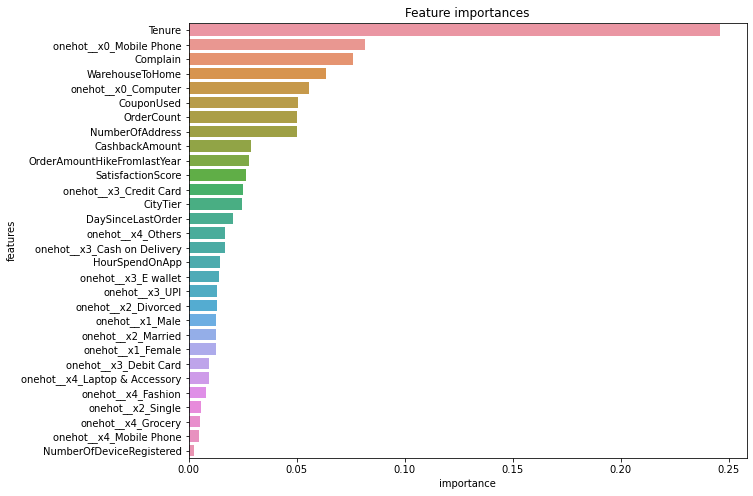

In [88]:
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='features', data = feature_importance.sort_values(by='importance', ascending=False))
plt.title('Feature importances')
plt.show()

From the feature importance graph above, it seems that the top 5 most important feature for the model is tenure, mobile phone preferred login device, complain, warehouse to home, and computer preferred login device.

Also, it can be seen that tenure is much more important than the next most important feature, as can be seen that it doubled in the value of the importance than the next most important features.

# Conclusion

In [89]:
print('Final Model \n\nModel Used: Random Forest\n\nROC-AUC Score: ', roc_auc_tuned, '\n\n', classification_report(y_test, y_pred_tuned))

Final Model 

Model Used: Random Forest

ROC-AUC Score:  0.9348027667786076 

               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1405
           1       0.94      0.88      0.91       284

    accuracy                           0.97      1689
   macro avg       0.96      0.93      0.95      1689
weighted avg       0.97      0.97      0.97      1689



Based on the classification report, according to the precision value, we could see the positive precision is 0.94 which means that, from this dataset, the model can correctly predict 94% of the customers that will churn. 

While according to the recall value, with the positive recall value of 0.88 we can conclude that the model can predict 88% of the customers that will actually churn. Since the dataset is imbalanced, we will ignore the accuracy value, since it does not represent the model's accuracy correctly.

In theory, we can calculate the amount of the revenue before and after the churn, from the revenue that the company will have before and after the churn, and the difference between the two are counted as the loss, and to compensate the loss of customers, the company will try to acquire more customers and thus, increase the amount of the acquisition cost, however, most sources states that it is cheaper to have customer retention as it usually costs less.

Thus, by using the model, we can predict customers that will churn, approach such customers and offer some promotions to prevent them from churning and attract them back to using the online store again.

So, according to this dataset,

- Total Customers Before Churn: 5630 people
- Total Customers that Churns: 948 people

From this dataset,

- Based on the positive recall, The model can detect: 0.88 * 948 = 834 people
- The model however missed: 0.12 * 948 = 114 people

Suppose that, Average revenue per customer across 2814 stores in 2022 is US$ 111 based on: https://www.littledata.io/average/revenue-per-customer 

And suppose that, Average customer acquisition cost in e-commerce is US$ 45.27 based on: https://blog.converted.in/en-us/blog/average-customer-acquisition-cost-in-ecommerce#REDUCE

Also suppose that, the customer retention cost is one-fifth of the customer acquisition cost, based on: https://www.moengage.com/learn/average-customer-retention-rate-by-industry/

Based on the test data if the company wanted to gain back the number of customer before the churn,

- Revenue before Churn: 1689 * 111 = USD 187,479
- Revenue after Churn: 1405 * 111  = USD 155,955
- Loss because of Churn: 284 * 111 = USD 31,524
- Customer Acquisition to equal before churn: 284 * 45.27 = USD 12,856.68
- Total loss: USD 12,856.68 

If the model is used, supposed that we give promotions and special deals to customers who are likely to churn and we manage to make the customers to not churn:

- Customer Retention(Churning Customers that is predicted) = 0.88 * 284 * 9 = USD 2,249.8 (Since we are trying to attract them back with extra offers)
- Missed Customer Loss Customer Acquisition: 0.12 * 284 * 45.27 = USD 1,542.8
- Total Loss: USD 2,249.8 + USD 1,542.8 = USD 3,792.6
- Total Saving: USD 12,856.68 - USD 3,792.6 = USD 9,064.08

However, there are still unpredictable pattern such as, customer still churning despite the promotions. But, there are still chances to acquire new customers free of cost, such as, new customers due to word-of-mouth from existing customers.



# Recommendations

In [90]:
x_test['Churn'] = y_test
x_test['Churn Probability'] = y_pred_proba_tuned[:,1]

In [92]:
x_test.groupby('Churn')['Churn Probability'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
0,1405.0,0.072060,0.092478,0.000,0.01500,0.0400,0.09,0.67
1,284.0,0.781338,0.202371,0.155,0.65375,0.8475,0.96,1.00


- Regarding the implementation of this model, we could use probability prediction to create a tiered promotion strategy, with several tiers, with predetermined probability threshold, we could push bigger promotions and e-mail to customers who have a higher probability to churn, and ease on promotions on customers who have less churn probability. For example, focus the promotion on people whose churn probability is higher than 80%, and give less promotions on customers who are 20% chance to churn
- From the exploratory data analysis and the feature importances, it can be seen that customers that had a complain have a higher churn rate than the customers that did not had complains, at about 21% higher churn rate and thus after the customer complains, offer some coupons or promotions. 
- Tenure is an important factor in the customer churn, with no customers with tenure of 25 churning, thus, give incentives and deals for people with medium tenure to build customer loyalty.
- Add more features regarding the customers' data such as, age and occupation, also, features such as, monthly spending amount of each customer could also help the model training.
- In addition to such features, we can also try to do some sentiment analysis on complains and reason that the customer churns for example, by assigning a positive value to positive sentiment and negative value for negative sentiment, by using the result of the model of the sentiment analysis, improvements can be made to the current model.
- If the company had a recommendation system currently implemented in the online store, perhaps data from each customer recommendation can be used for each of the customer's promotions or coupons target.
- Try other Machine Learning models and expand upon the hyperparameter tuning.